In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt



In [4]:
import numpy as np
import pandas as pd

In [5]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
# Using the inspector to print the column names within the 'measurement' table and its types
from sqlalchemy import inspect
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
#look at data to see how date variable is formatted
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [14]:
# Using the inspector to print the column names within the 'station' table and its types
from sqlalchemy import inspect
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [111]:
session.query(Measurement.date).order_by(Measurement.date.desc()).first() 

('2017-08-23')

In [117]:
dt.datetime.strptime(session.query(func.max(Measurement.date)).all()[0][0], "%Y-%m-%d")

datetime.datetime(2017, 8, 23, 0, 0)

In [126]:
results = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
            filter(Measurement.date >= dt.datetime.strptime("2015-04-15", "%Y-%m-%d")).\
                filter(Measurement.date <= dt.datetime.strptime("2015-04-30", "%Y-%m-%d")).all()
len(results[0])

3

In [116]:
dt.datetime.strptime(session.query(func.max(Measurement.date)).all()[0][0], "%Y-%m-%d")-dt.timedelta(days = 366)

datetime.datetime(2016, 8, 22, 0, 0)

In [104]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first() 
in_datetime = dt.datetime.strptime(last_date[0], "%Y-%m-%d")
last_year = in_datetime - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
last_year_prcp = session.query(Measurement.date, func.sum(Measurement.prcp)).\
    filter(Measurement.date >= last_year).\
       group_by(Measurement.date).\
       order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(last_year_prcp, columns=['Date', 'Total Precipitation'])
prcp_df.set_index('Date', inplace=True)




In [105]:
prcp_df = prcp_df.sort_values('Date') 
prcp_df.head()

,Total Precipitation
Date,
2016-08-23,2.71
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32


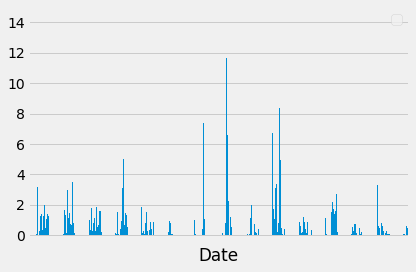

In [106]:
# Sort the dataframe by date
#prcp_df.set_index('Date', inplace=True)
#prcp_df = prcp_df.sort_values('Date') 

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot.bar()
plt.xticks([])
plt.legend([])
plt.ylim(-.5,15)
plt.tight_layout()
plt.show()
#plt.savefig('test.png')

![precipitation](Images/precipitation.png)

In [48]:
# Perform a query to retrieve the data and precipitation scores
last_year_prcp_2 = session.query(Measurement.date, Measurement.prcp, Measurement.station).\
    filter(Measurement.date >= last_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df2 = pd.DataFrame(last_year_prcp_2, columns=['Date', 'Total Precipitation',"Station"])
prcp_sum = pd.DataFrame(prcp_df2["Total Precipitation"].describe())
#prcp_sum = 
prcp_sum

,Total Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [ ]:
# Use Pandas to calcualte the summary statistics for the precipitation data

![describe](Images/describe.png)

In [56]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(Measurement.station.distinct())).all()
station_count

[(9)]

In [91]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_counts = session.query(Measurement.station, func.count(Measurement.prcp), func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.prcp).desc()).all()
station_counts

[('USC00519281', 2772, 2772),
 ('USC00513117', 2696, 2709),
 ('USC00519397', 2685, 2724),
 ('USC00519523', 2572, 2669),
 ('USC00516128', 2484, 2612),
 ('USC00514830', 1937, 2202),
 ('USC00511918', 1932, 1979),
 ('USC00517948', 683, 1372),
 ('USC00518838', 342, 511)]

In [78]:
#station with hightest number of obs.
most_active = station_counts[0][0]

In [87]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
ma_station = pd.DataFrame(session.query(Measurement.station, func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active).\
    group_by(Measurement.station).all(), columns = ["Station","Maximum Temperature","Minimum Temperature","Average Temperature"])
ma_station

,Station,Maximum Temperature,Minimum Temperature,Average Temperature
0,USC00519281,85.0,54.0,71.663781


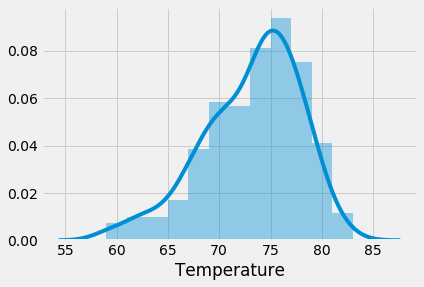

In [107]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
import seaborn as sns
last_year_ma = pd.DataFrame(session.query(Measurement.tobs).\
    filter(Measurement.date >= last_year, Measurement.station == most_active).all(), columns = ["Temperature"])
last_year_ma
sns.distplot(last_year_ma["Temperature"], bins = 12)

In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


![precipitation](Images/station-histogram.png)

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.

    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
